# Data Analysis: Self-Report

In this notebook, we wil be reading in the UV and then analysing the data according to the following hypotheses:

- H1:Long form viewing is associated with greater Enjoyment than Short form viewing (our rationale is that emotional engagement and narrative development are enhanced in Long form (i.e., in narrative context), which may increase Enjoyment).
- H3:Long form viewing is associated with better Recall than Short form viewing (rationale = contextual information aids memory encoding and retrieval).
- H5:Participants who are more Familiar with a Title may report higher Enjoyment than participants who are less familiar (rationale = prior exposure may increase emotional engagement and understanding of the content)
- H5:Participants who are more Familiar with a Title may report higher Enjoyment than participants who are less familiar, split by format
- H6:Participants who are more Familiar with a Title will show better Recall on average than those who are less familiar (rationale = familiarity may support memory retrieval through mental schema activation).
- E5:Is there a positive relationship between Enjoyment and Recall?

In addition to testing the hypothesis, we will also be generating visualisations as graphs. We must conduct appropriate statistical tests, and display the results of these tests on the graph itself as subtext.

Our design was a 2 x 2 between-subjects factorial:
- Factor 1 = Format (short form versus long form)
- Factor 2 = Familiarity with Title (we used a scale and decided on treating Familiarity as a moderator). The scores used for this will be the Screening questionnaire familiarity
- Random factor / variable = Titles / Genres (we're not focusing on specific Title / Genre interactions. Our focus is on the Format effect).

The 3 Target titles that we are mainly interested in are:
- Mad Max
- The Town
- Abbot Elementary

Other titles which appear in the data are there for control, comparison or as distractors. Therefore, hypotheses will primarily be answered using data from the target titles.

## Data Setup
We start by loading the unified view and preparing helpers for the column category inventory.

In [38]:
import csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import statsmodels.formula.api as smf
from scipy import stats

plt.rcParams['font.family'] = "Century Gothic"
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 10})

# Example of formatting
# for spine in ["top", "right"]:
#         ax.spines[spine].set_visible(False)
#     ax.grid(axis="y", linestyle="--", alpha=0.3)
#     plt.tight_layout()
#     plt.show()

COLOR_MAP = {'Long': "#265f88",
             'Short': "#aa55c4",
             'Default': 'deepskyblue'}


In [39]:
PROJECT_ROOT = Path.cwd().parent
UV_PATH = PROJECT_ROOT / "results" / "uv_merged.csv"

uv = pd.read_csv(UV_PATH)
uv.head()

,source_file,group,respondent,date_study,time_study,age,age_group,gender,ethnicity,income_group,...,distractor_Post_Recognition_Sum,fake_Post_Recognition_Count,fake_Post_Recognition_Mean,fake_Post_Recognition_NormalizedMean,fake_Post_Recognition_Sum,unseen_Post_Recognition_Count,unseen_Post_Recognition_Mean,unseen_Post_Recognition_NormalizedMean,unseen_Post_Recognition_Sum,post_survey_source_path
0,003_104.csv,A,104,10/16/2025,18:09:03,59,44-59,Male,White,"$60,000 or more per year",...,8.0,4.0,5.5,0.6875,22.0,1.0,0.0,0.0,0.0,data/Post/Group A_ Post Viewing Questionnaire ...
1,002_106.csv,A,106,10/16/2025,19:35:05,30,28-43,Male,White,"$60,000 or more per year",...,16.0,4.0,8.0,1.0000,32.0,1.0,6.0,0.0,6.0,data/Post/Group A_ Post Viewing Questionnaire ...
2,001_116.csv,A,116,10/18/2025,12:37:40,19,18-27,Male,White,"$35,000  $60,000 per year",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,006_14.csv,A,14,10/11/2025,09:32:42,33,28-43,Male,Hispanic/Latino/Latina/Latinx,"$60,000 or more per year",...,8.0,4.0,6.5,0.6250,26.0,1.0,8.0,1.0,8.0,data/Post/Group A_ Post Viewing Questionnaire ...
4,007_3.csv,A,3,10/10/2025,09:19:22,34,28-43,Female,White,"$60,000 or more per year",...,16.0,4.0,8.0,0.0000,32.0,1.0,8.0,0.0,8.0,data/Post/Group A_ Post Viewing Questionnaire ...


In [40]:
demographic_exact = {
    "respondent_id",
    "group",
    "age",
    "age_group",
    "gender",
    "ethnicity",
    "income_group",
    "content_consumption",
    "grid_comments",
    "date_study",
    "time_study",
    "post_survey_source_path"
}

demographic_keywords = ("demographic", "respondent", "grid", "age", "gender", "ethnic", "income", "content_consumption", "comments", "group")
enjoyment_keywords = ("enjoy",)
familiarity_keywords = ("familiar",)
recognition_keywords = ("recognition", "recall")

def assign_category(column_name: str) -> str:
    name_lower = column_name.lower()
    if column_name in demographic_exact or any(keyword in name_lower for keyword in demographic_keywords):
        return "demographics"
    if any(keyword in name_lower for keyword in enjoyment_keywords):
        return "enjoyment"
    if any(keyword in name_lower for keyword in familiarity_keywords):
        return "familiarity"
    if any(keyword in name_lower for keyword in recognition_keywords):
        return "recognition"
    return "other"

column_categories = [assign_category(column) for column in uv.columns]

column_category_df = pd.DataFrame({
    "header": uv.columns,
    "category": column_categories,
})

category_csv_path = PROJECT_ROOT / "results" / "uv_column_categories.csv"
column_category_df.to_csv(category_csv_path, index=False)

column_category_df["category"].value_counts().to_frame()

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\ashra\\Documents\\NeuralSense\\NeuralData\\clients\\544_WBD_CXCU\\results\\uv_column_categories.csv'

## Hypothesis 1 – Format and Enjoyment
We evaluate whether long-form content drives greater enjoyment than short-form content using the unified view (`uv_merged.csv`). The workflow below:
- isolates the enjoyment composites and reshapes them into a tidy form;
- runs within-subject tests on respondents who experienced both formats (Part 1);
- fits title-level mixed-effects models that treat title as a random intercept (Part 2);
- expands the analysis to normalized enjoyment subscales; and
- inventories the question counts contributing to each subscale so we can interpret scaling differences.

Part 1 emphasises the normalized composites that put short and long forms on the same 0–1 scale. Part 2 retains the broader composite set to check whether title-level effects replicate across alternative scalings.

In [ ]:
[col for col in uv.columns if "Enjoyment" in col][:20]

['Long_The Town_Survey_Enjoyment_E1',
 'Long_The Town_Survey_Enjoyment_E12',
 'Long_The Town_Survey_Enjoyment_E14',
 'Long_The Town_Survey_Enjoyment_E15',
 'Long_The Town_Survey_Enjoyment_E17',
 'Long_The Town_Survey_Enjoyment_E18',
 'Long_The Town_Survey_Enjoyment_E19',
 'Long_The Town_Survey_Enjoyment_E2',
 'Long_The Town_Survey_Enjoyment_E20',
 'Long_The Town_Survey_Enjoyment_E3',
 'Long_The Town_Survey_Enjoyment_E4',
 'Long_The Town_Survey_Enjoyment_E9',
 'Short_Mad Max_Survey_Enjoyment_E1',
 'Short_Mad Max_Survey_Enjoyment_E12',
 'Short_Mad Max_Survey_Enjoyment_E14',
 'Short_Mad Max_Survey_Enjoyment_E15',
 'Short_Mad Max_Survey_Enjoyment_E17',
 'Short_Mad Max_Survey_Enjoyment_E18',
 'Short_Mad Max_Survey_Enjoyment_E19',
 'Short_Mad Max_Survey_Enjoyment_E2']

In [ ]:
[col for col in uv.columns if "EnjoymentComposite" in col]

['Long_The Town_Survey_EnjoymentComposite_Count',
 'Long_The Town_Survey_EnjoymentComposite_Sum',
 'Long_The Town_Survey_EnjoymentComposite_Corrected',
 'Long_The Town_Survey_EnjoymentComposite_Mean',
 'Long_The Town_Survey_EnjoymentComposite_Normalized',
 'Long_The Town_Survey_EnjoymentComposite_NormalizedCorrected',
 'Short_Mad Max_Survey_EnjoymentComposite_Count',
 'Short_Mad Max_Survey_EnjoymentComposite_Sum',
 'Short_Mad Max_Survey_EnjoymentComposite_Corrected',
 'Short_Mad Max_Survey_EnjoymentComposite_Mean',
 'Short_Mad Max_Survey_EnjoymentComposite_Normalized',
 'Short_Mad Max_Survey_EnjoymentComposite_NormalizedCorrected',
 'Long_Mad Max_Survey_EnjoymentComposite_Count',
 'Long_Mad Max_Survey_EnjoymentComposite_Sum',
 'Long_Mad Max_Survey_EnjoymentComposite_Corrected',
 'Long_Mad Max_Survey_EnjoymentComposite_Mean',
 'Long_Mad Max_Survey_EnjoymentComposite_Normalized',
 'Long_Mad Max_Survey_EnjoymentComposite_NormalizedCorrected',
 'Short_The Town_Survey_EnjoymentComposite_Cou

In [ ]:
import re

ENJOYMENT_METRICS_ALL = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
    "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean",
]
METRIC_LABELS = {
    "EnjoymentComposite_Normalized": "EnjoymentComposite_Normalised",
    "EnjoymentComposite_NormalizedCorrected": "EnjoymentComposite_NormalisedCorrected",
    "EnjoymentComposite_Sum": "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected": "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean": "EnjoymentComposite_Mean",
}
METRIC_YLABELS = {
    "EnjoymentComposite_Normalized": "Normalized Enjoyment Score",
    "EnjoymentComposite_NormalizedCorrected": "Normalized Enjoyment Score",
    "EnjoymentComposite_Sum": "Composite Enjoyment Sum",
    "EnjoymentComposite_Corrected": "Polarity-Corrected Sum",
    "EnjoymentComposite_Mean": "Average Enjoyment Score",
}
PART1_METRICS = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
]
PART2_METRICS = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
    "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean",
]
TARGET_TITLES = ["Mad Max", "The Town", "Abbot Elementary"]

id_column = "respondent_id" if "respondent_id" in uv.columns else uv.columns[0]

long_frames = []
for metric in ENJOYMENT_METRICS_ALL:
    metric_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(metric)}$")
    metric_columns = [col for col in uv.columns if metric_pattern.match(col)]
    for column in metric_columns:
        form, title_token = metric_pattern.match(column).groups()
        title_clean = title_token.replace("_", " ").strip()
        frame = (
            uv[[id_column, column]]
            .rename(columns={column: "value"})
            .assign(form=form, title=title_clean, metric=metric)
)
        long_frames.append(frame)

if not long_frames:
    raise ValueError("No enjoyment columns matching the expected pattern were found in uv_merged.csv")

enjoyment_long = (
    pd.concat(long_frames, ignore_index=True)
    .dropna(subset=["value"])
)
enjoyment_long[id_column] = enjoyment_long[id_column].astype(str)
enjoyment_long["form"] = pd.Categorical(enjoyment_long["form"], categories=["Short", "Long"], ordered=True)

title_overview = enjoyment_long.groupby(["metric", "title", "form"], observed=True).size().rename("records").reset_index()
title_overview

,metric,title,form,records
0,EnjoymentComposite_Corrected,Abbot Elementary,Short,30
1,EnjoymentComposite_Corrected,Abbot Elementary,Long,30
2,EnjoymentComposite_Corrected,Mad Max,Short,26
3,EnjoymentComposite_Corrected,Mad Max,Long,23
4,EnjoymentComposite_Corrected,The Town,Short,26
5,EnjoymentComposite_Corrected,The Town,Long,28
6,EnjoymentComposite_Mean,Abbot Elementary,Short,30
7,EnjoymentComposite_Mean,Abbot Elementary,Long,30
8,EnjoymentComposite_Mean,Mad Max,Short,26
9,EnjoymentComposite_Mean,Mad Max,Long,23


### Part 1: Normalized Within-Subject Comparison
For each enjoyment composite we average the Long and Short responses per respondent and run a paired, one-tailed t-test on the Long–Short difference (expecting Long > Short). Plots are restricted to the normalized variants so visual conclusions align to the per-item scaling.

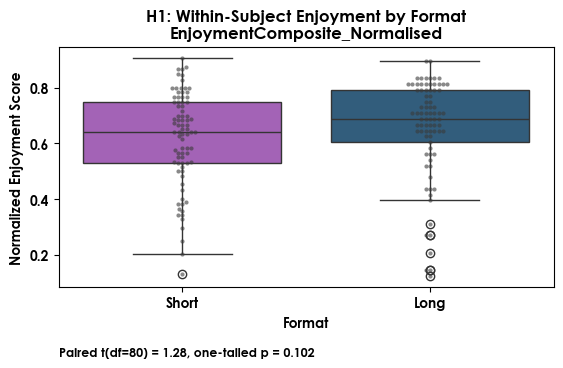

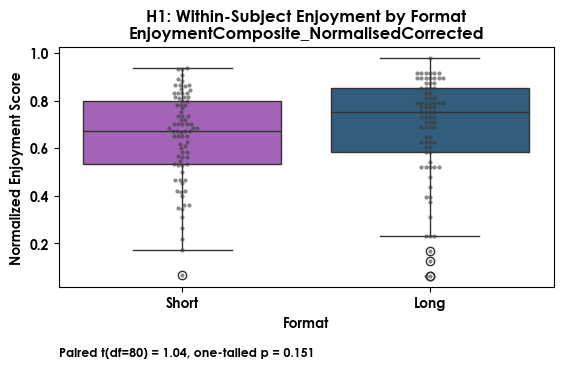

,metric,n_paired,t_stat,df,p_one_tailed
0,EnjoymentComposite_Normalised,81,1.281099,80,0.101930
1,EnjoymentComposite_NormalisedCorrected,81,1.039125,80,0.150939


In [ ]:
def one_tailed_p_from_paired_t(long_values, short_values):
    paired = pd.DataFrame({"Long": long_values, "Short": short_values}).dropna()
    if paired.empty:
        raise ValueError("No respondents have both Long and Short enjoyment scores available.")
    t_stat, p_two = stats.ttest_rel(paired["Long"], paired["Short"], nan_policy="omit")
    df = paired.shape[0] - 1
    p_one = stats.t.sf(t_stat, df)
    return t_stat, df, p_one, paired

within_subject_summaries = []

for metric in PART1_METRICS:
    metric_label = METRIC_LABELS[metric]
    metric_df = enjoyment_long.loc[enjoyment_long["metric"] == metric]
    respondent_means = metric_df.groupby([id_column, "form"], observed=True)['value'].mean().unstack()
    try:
        t_stat, df_val, p_one, paired = one_tailed_p_from_paired_t(respondent_means["Long"], respondent_means["Short"])
    except ValueError as exc:
        print(f"{metric_label}: {exc}")
        continue
    within_subject_summaries.append({
        "metric": metric_label,
        "n_paired": paired.shape[0],
        "t_stat": t_stat,
        "df": df_val,
        "p_one_tailed": p_one,
    })
    plot_data = paired.reset_index().melt(id_vars=id_column, value_vars=["Short", "Long"], var_name="form", value_name="value")
    palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.28, right=0.95)
    sns.boxplot(data=plot_data, x="form", y="value", order=["Short", "Long"], hue="form", palette=palette, dodge=False, legend=False, ax=ax)
    sns.swarmplot(data=plot_data, x="form", y="value", order=["Short", "Long"], color="#3a3a3a", size=3, alpha=0.6, ax=ax)
    ax.set_title(f"H1: Within-Subject Enjoyment by Format\n{metric_label}")
    ax.set_xlabel("Format")
    ax.set_ylabel(METRIC_YLABELS.get(metric, "Enjoyment Score"))
    annotation = f"Paired t(df={df_val}) = {t_stat:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.25, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()

pd.DataFrame(within_subject_summaries)

### Part 2: Mixed Models by Title
We restrict to the three target titles, convert format into a binary predictor, and fit mixed-effects models with title as a random intercept. The coefficient on `form_long` estimates the expected Long–Short lift while accounting for title-to-title variability. Visuals highlight each title’s distribution alongside the model summary.

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

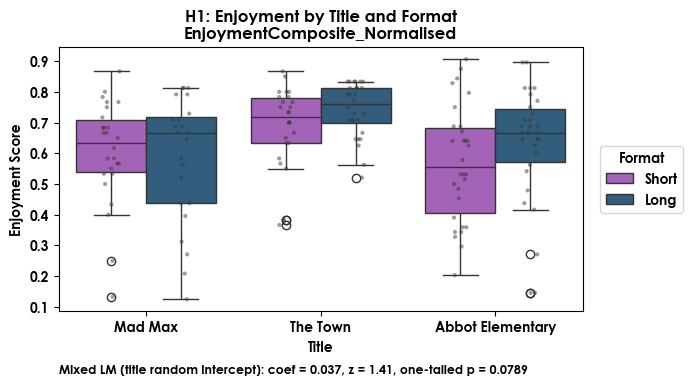

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

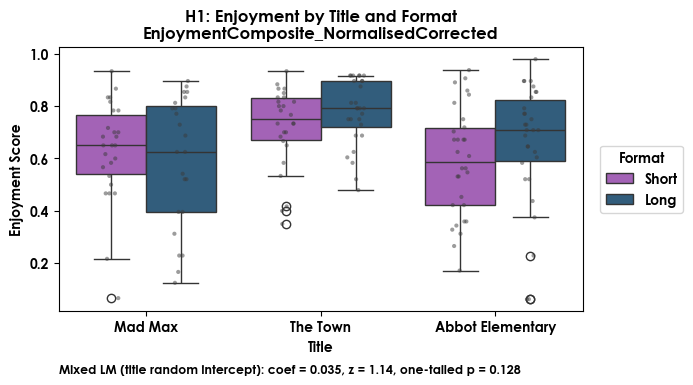

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

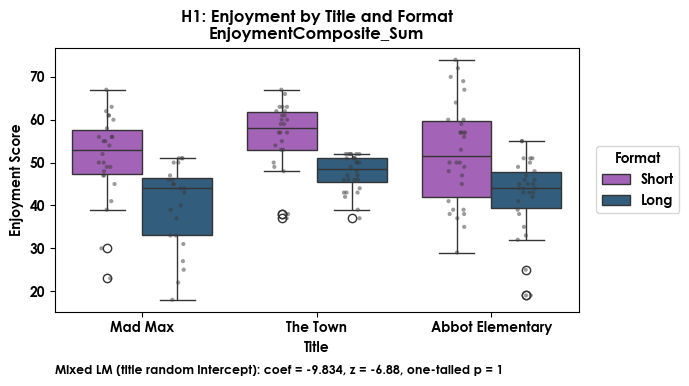

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

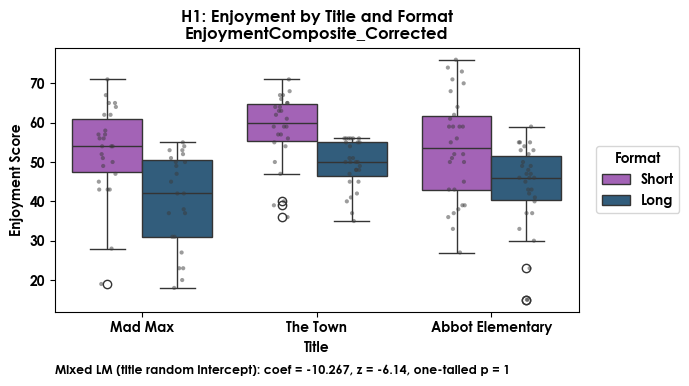

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

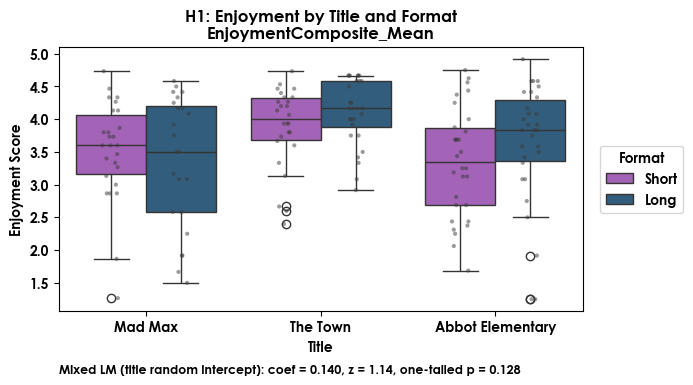

,metric,coef_form_long,z_value,p_one_tailed,n_observations,titles_included
0,EnjoymentComposite_Normalised,0.036647,1.412361,0.078922,163,3
1,EnjoymentComposite_NormalisedCorrected,0.034928,1.135218,0.128142,163,3
2,EnjoymentComposite_Sum,-9.834368,-6.879121,1.000000,163,3
3,EnjoymentComposite_Corrected,-10.267069,-6.136619,1.000000,163,3
4,EnjoymentComposite_Mean,0.139712,1.135218,0.128142,163,3


In [ ]:
between_subject_summaries = []
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}

for metric in PART2_METRICS:
    metric_label = METRIC_LABELS[metric]
    subset = enjoyment_long.loc[
        (enjoyment_long["metric"] == metric)
        & enjoyment_long["title"].isin(TARGET_TITLES)
    ].copy()
    if subset.empty:
        print(f"No data available for {metric_label} when filtering to target titles.")
        continue
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
    except Exception as exc:
        print(f"Mixed model failed for {metric_label}: {exc}")
        continue
    coef = mixed_result.params.get("form_long", np.nan)
    se = mixed_result.bse.get("form_long", np.nan)
    z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
    p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    between_subject_summaries.append({
        "metric": metric_label,
        "coef_form_long": coef,
        "z_value": z_val,
        "p_one_tailed": p_one,
        "n_observations": subset.shape[0],
        "titles_included": subset["title"].nunique(),
    })
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.22, right=0.78)
    sns.boxplot(data=subset, x="title", y="value", hue="form", palette=palette, order=TARGET_TITLES, hue_order=["Short", "Long"], ax=ax)
    sns.stripplot(data=subset, x="title", y="value", hue="form", palette={"Short": "#3a3a3a", "Long": "#3a3a3a"}, order=TARGET_TITLES, hue_order=["Short", "Long"], dodge=True, size=3, alpha=0.5, ax=ax, legend=False)
    ax.set_title(f"H1: Enjoyment by Title and Format\n{metric_label}")
    ax.set_xlabel("Title")
    ax.set_ylabel("Enjoyment Score")
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.2, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()

pd.DataFrame(between_subject_summaries)

### Subscale Decomposition
To understand which facets of enjoyment shift with format, the next block reshapes the normalized subscale scores, reuses the paired t-test function for within-subject contrasts, and repeats the mixed-model checks at the title level. Each plot uses the normalized 0–1 scale for comparability across subscales.

In [ ]:
ENJOYMENT_SUBSCALES = [
    "Nostalgia",
    "Confusion",
    "Evocative",
    "Entertainment",
    "Interest",
    "Connection",
    "Attention",
]
subscale_frames = []
for subscale in ENJOYMENT_SUBSCALES:
    subscale_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(subscale)}_Normalized$")
    matched_columns = [col for col in uv.columns if subscale_pattern.match(col)]
    if not matched_columns:
        print(f"No normalized survey columns found for subscale {subscale}; skipping column build.")
        continue
    for column in matched_columns:
        form, title_token = subscale_pattern.match(column).groups()
        title_clean = title_token.replace("_", " ").strip()
        frame = (
            uv[[id_column, column]]
            .rename(columns={column: "value"})
            .assign(form=form, title=title_clean, subscale=subscale)
        )
        subscale_frames.append(frame)
if not subscale_frames:
    raise ValueError("No enjoyment subscale columns matching the expected pattern were found in uv_merged.csv")
subscale_long = (
    pd.concat(subscale_frames, ignore_index=True)
    .dropna(subset=["value"])
)
subscale_long[id_column] = subscale_long[id_column].astype(str)
subscale_long["form"] = pd.Categorical(subscale_long["form"], categories=["Short", "Long"], ordered=True)
subscale_long["subscale"] = pd.Categorical(subscale_long["subscale"], categories=ENJOYMENT_SUBSCALES, ordered=True)
subscale_title_overview = subscale_long.groupby(["subscale", "title", "form"], observed=True).size().rename("records").reset_index()
subscale_title_overview

,subscale,title,form,records
0,Nostalgia,Abbot Elementary,Short,30
1,Nostalgia,Mad Max,Short,26
2,Nostalgia,The Town,Short,26
3,Confusion,Abbot Elementary,Short,30
4,Confusion,Abbot Elementary,Long,30
5,Confusion,Mad Max,Short,26
6,Confusion,Mad Max,Long,23
7,Confusion,The Town,Short,26
8,Confusion,The Town,Long,28
9,Evocative,Abbot Elementary,Short,30


Nostalgia: requires both Short and Long format data for paired comparison; skipping.


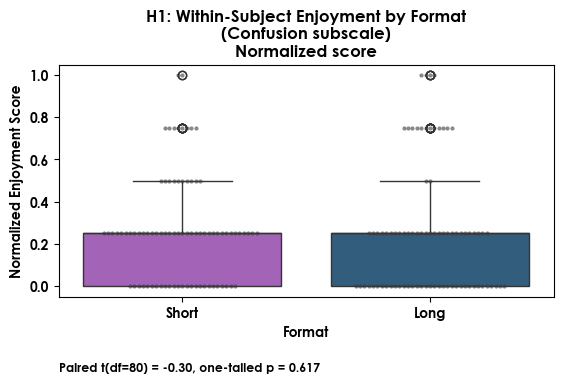

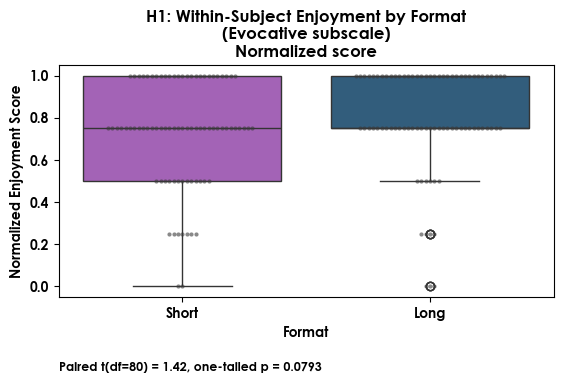

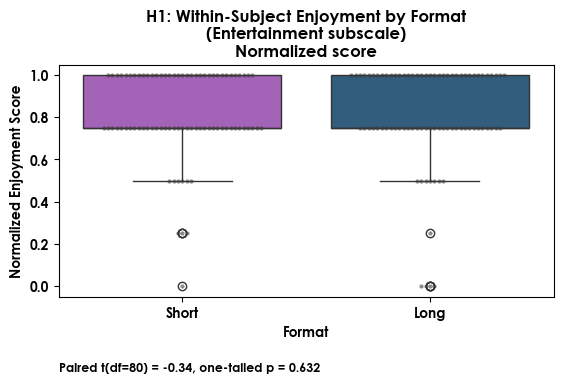

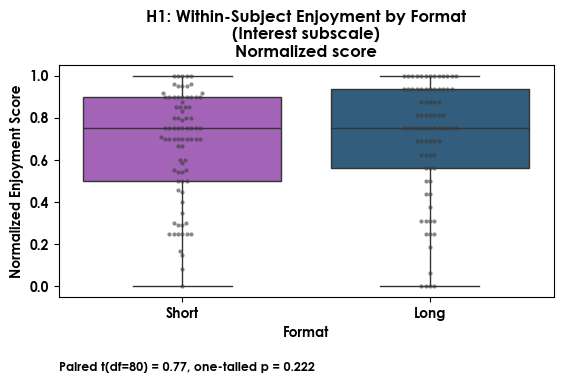

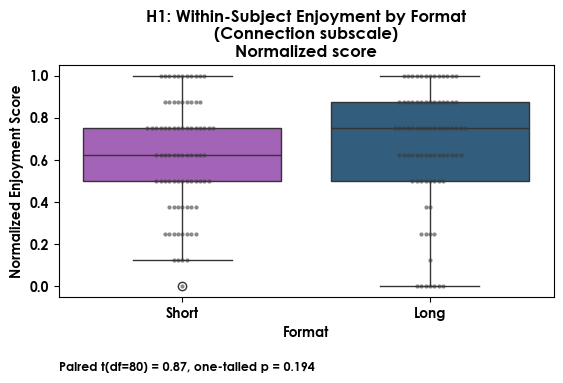

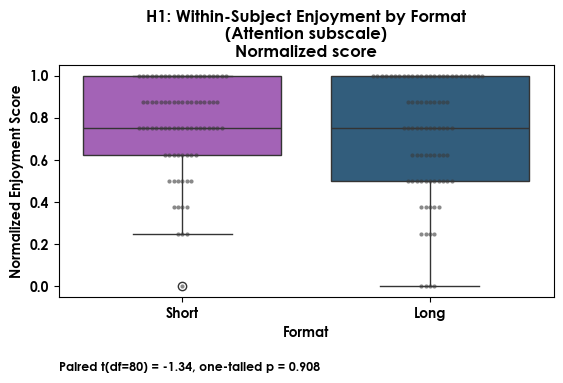

,subscale,n_paired,t_stat,df,p_one_tailed
0,Confusion,81,-0.298122,80,0.616808
1,Evocative,81,1.423136,80,0.079292
2,Entertainment,81,-0.338637,80,0.632115
3,Interest,81,0.770105,80,0.221753
4,Connection,81,0.869230,80,0.193661
5,Attention,81,-1.340126,80,0.908001


In [ ]:
subscale_within_subject_summaries = []
for subscale in ENJOYMENT_SUBSCALES:
    metric_df = subscale_long.loc[subscale_long["subscale"] == subscale]
    if metric_df.empty:
        print(f"{subscale}: no normalized survey data available; skipping within-subject analysis.")
        continue
    respondent_means = metric_df.groupby([id_column, "form"], observed=True)["value"].mean().unstack()
    if not {"Short", "Long"}.issubset(respondent_means.columns):
        print(f"{subscale}: requires both Short and Long format data for paired comparison; skipping.")
        continue
    try:
        t_stat, df_val, p_one, paired = one_tailed_p_from_paired_t(respondent_means["Long"], respondent_means["Short"])
    except ValueError as exc:
        print(f"{subscale}: {exc}")
        continue
    subscale_within_subject_summaries.append({
        "subscale": subscale,
        "n_paired": paired.shape[0],
        "t_stat": t_stat,
        "df": df_val,
        "p_one_tailed": p_one,
    })
    plot_data = paired.reset_index().melt(id_vars=id_column, value_vars=["Short", "Long"], var_name="form", value_name="value")
    palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.3, right=0.95)
    sns.boxplot(data=plot_data, x="form", y="value", order=["Short", "Long"], hue="form", palette=palette, dodge=False, legend=False, ax=ax)
    sns.swarmplot(data=plot_data, x="form", y="value", order=["Short", "Long"], color="#3a3a3a", size=3, alpha=0.6, ax=ax)
    ax.set_title(f"H1: Within-Subject Enjoyment by Format\n({subscale} subscale)\nNormalized score")
    ax.set_xlabel("Format")
    ax.set_ylabel("Normalized Enjoyment Score")
    annotation = f"Paired t(df={df_val}) = {t_stat:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.28, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()
pd.DataFrame(subscale_within_subject_summaries)

Nostalgia: requires both formats for mixed model; skipping.


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

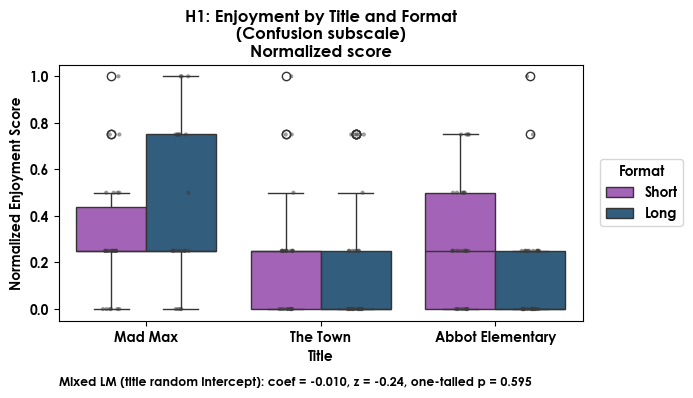

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

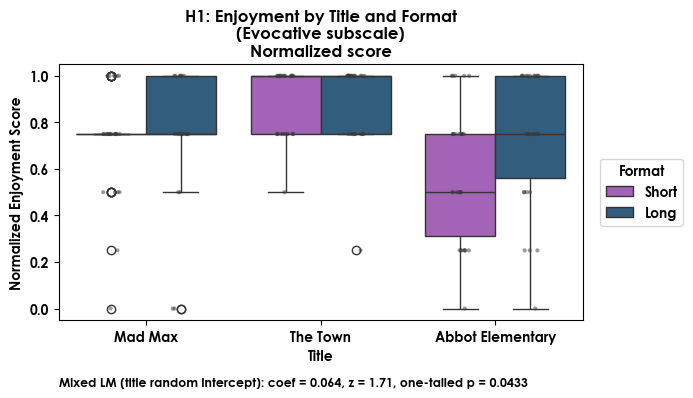

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

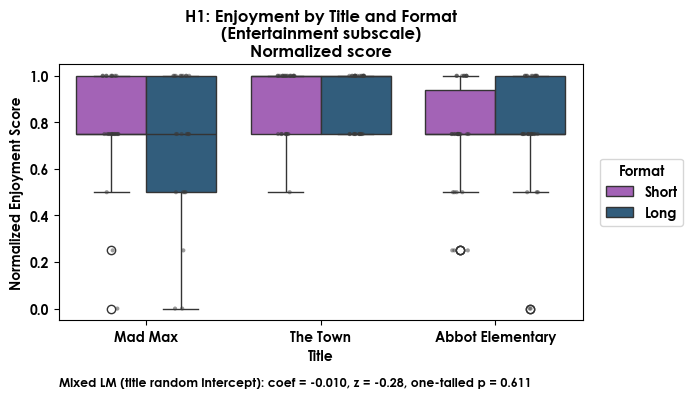

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

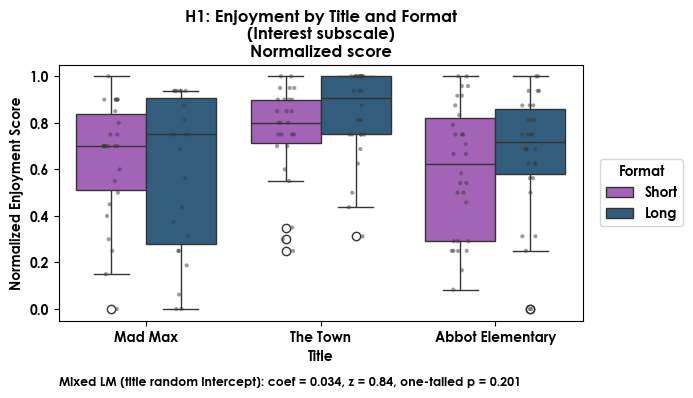

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

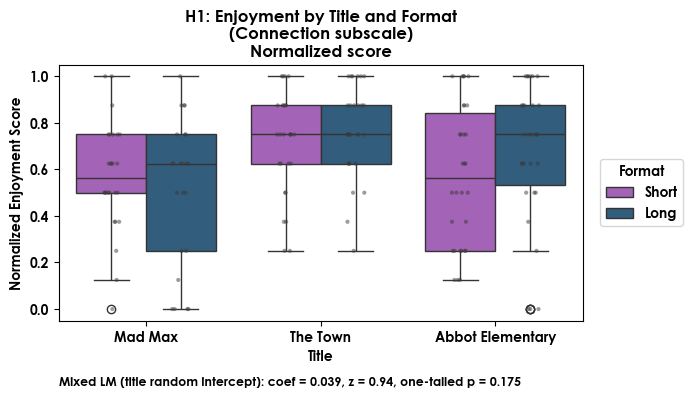

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

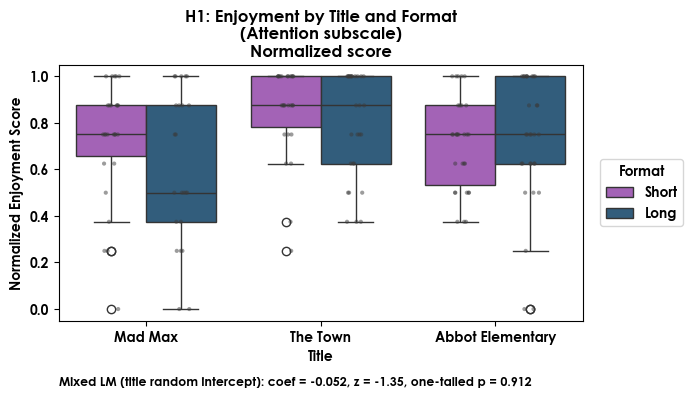

,subscale,coef_form_long,z_value,p_one_tailed,n_observations,titles_included
0,Confusion,-0.010353,-0.241576,0.595446,163,3
1,Evocative,0.063653,1.713354,0.043324,163,3
2,Entertainment,-0.009786,-0.280689,0.610526,163,3
3,Interest,0.033529,0.837503,0.201155,163,3
4,Connection,0.038714,0.935978,0.174642,163,3
5,Attention,-0.052244,-1.350308,0.911541,163,3


In [ ]:
subscale_between_subject_summaries = []
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
for subscale in ENJOYMENT_SUBSCALES:
    subset = subscale_long.loc[
        (subscale_long["subscale"] == subscale)
        & (subscale_long["title"].isin(TARGET_TITLES))
    ].copy()
    if subset.empty:
        print(f"{subscale}: no normalized survey data available after filtering to target titles; skipping mixed model.")
        continue
    if subset["form"].nunique() < 2:
        print(f"{subscale}: requires both formats for mixed model; skipping.")
        continue
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
    except Exception as exc:
        print(f"Mixed model failed for {subscale} subscale: {exc}")
        continue
    coef = mixed_result.params.get("form_long", np.nan)
    se = mixed_result.bse.get("form_long", np.nan)
    z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
    p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    subscale_between_subject_summaries.append({
        "subscale": subscale,
        "coef_form_long": coef,
        "z_value": z_val,
        "p_one_tailed": p_one,
        "n_observations": subset.shape[0],
        "titles_included": subset["title"].nunique(),
    })
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.24, right=0.78)
    sns.boxplot(data=subset, x="title", y="value", hue="form", palette=palette, order=TARGET_TITLES, hue_order=["Short", "Long"], ax=ax)
    sns.stripplot(data=subset, x="title", y="value", hue="form", palette={"Short": "#3a3a3a", "Long": "#3a3a3a"}, order=TARGET_TITLES, hue_order=["Short", "Long"], dodge=True, size=3, alpha=0.5, ax=ax, legend=False)
    ax.set_title(f"H1: Enjoyment by Title and Format\n({subscale} subscale)\nNormalized score")
    ax.set_xlabel("Title")
    ax.set_ylabel("Normalized Enjoyment Score")
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
pd.DataFrame(subscale_between_subject_summaries)

### Subscale Item Counts
Different subscales sometimes include varying numbers of questions per respondent. The table below inventories the observed counts so we can explain scaling differences (e.g., higher sums arising from more answered items).

In [ ]:
subscale_item_counts = []
for subscale in ENJOYMENT_SUBSCALES:
    count_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(subscale)}_Count$")
    matched_columns = [col for col in uv.columns if count_pattern.match(col)]
    observed_counts = set()
    for column in matched_columns:
        values = uv[column].dropna()
        values = values[values > 0]
        if values.empty:
            continue
        observed_counts.update(values.astype(int).tolist())
    if observed_counts:
        counts_sorted = sorted(observed_counts)
        subscale_item_counts.append({
            "subscale": subscale,
            "question_count": counts_sorted[-1],
            "all_observed_counts": ", ".join(str(count) for count in counts_sorted),
        })
    else:
        subscale_item_counts.append({
            "subscale": subscale,
            "question_count": np.nan,
            "all_observed_counts": "No data",
        })
subscale_item_table = pd.DataFrame(subscale_item_counts).sort_values("subscale").reset_index(drop=True)
subscale_item_table

,subscale,question_count,all_observed_counts
0,Attention,2,2
1,Confusion,1,1
2,Connection,2,2
3,Entertainment,1,1
4,Evocative,1,1
5,Interest,6,"4, 5, 6"
6,Nostalgia,1,1
